## MCMC

ベイズ推定を軽くやり終えたので次のテーマであるMCMCを実装する。

MCMCとは

> マルコフ連鎖モンテカルロ法（Markov chain Monte Carlo methods、MCMC）　の略であり、求めたい確率分布をマルコフ連鎖を作成することをもとに、確率分布のサンプリングを行うアルゴリズムの総称である。

ここでマルコフ連鎖とは

> 確率過程の一種であり、未来$t+1$の挙動が現在$t$の値だけで決定され、過去の挙動と無関係である（マルコフ性）。各時刻において起こる状態変化（遷移または推移）に関して、マルコフ連鎖は遷移確率が過去の状態によらず、現在の状態のみによる系列である。

難しそうに聞こえますが簡単です。明日の飯が今日の気分だけで決まる感じです。たとえば明日ラーメン食べたいとして、今日も晩ご飯がラーメンだとするじゃないですか、するとまぁギリギリ食べれますよね。けどもし昨日もラーメン食べてたら「３日連続ラーメン」ということになりますが、マルコフ性があると昨日の飯のことは考慮しないので最大でも「２日連続」になるんです。


（ちなみに遷移行列については強化学習を勉強していてそちらで出てきているので機会があればまとめる）

ベイズ推定について述べた際に、$P(D)$の部分が解析的に解けないことがよくあると言った

- [Bayes Estimation by MIIDAS RESEARCH](https://research.miidas.jp/2019/12/%e3%83%99%e3%82%a4%e3%82%b8%e3%82%a2%e3%83%b3%e5%85%a5%e9%96%80%e3%80%80%e3%83%99%e3%82%a4%e3%82%ba%e6%8e%a8%e5%ae%9a/)

たとば多変量になればなるほど積分がシンドイのは自明だろう。

ということで確率分布を直接求めるのではなく、そこからサンプリングして擬似的に求めようというものだ。

## Gibbs Sampling

で、MCMCの一つであるギブスサンプリングを今回やる

これは確率分布を条件付き確率分布に無理やり分解して一変量ずつサンプリングしようという作戦。

もちろん、マルコフ性を仮定している。たとえば$p(x,y)$という２変量の同時分布からサンプリングするよりも$p(x|y)$の方が簡単ですよね。次元が一つ減ってるようなものなので。

で、このアルゴリズムはCoordinate descentに似てます。

- [Coordinate Descent (Lasso Algorithm)](https://research.miidas.jp/2019/02/lasso%e3%81%ae%e6%9c%80%e9%81%a9%e5%8c%96%e3%82%a2%e3%83%ab%e3%82%b4%e3%83%aa%e3%82%ba%e3%83%a0%e3%81%ae%e8%80%83%e5%af%9f/)

注目する変数以外を固定して計算していくので座標降下法のようにジグザグにサンプリングされます。

で、もちろん初期値は適当に選ぶんですけど、バーンインというものがあります。これは初期値から一定時間までの間に得られたサンプルは捨てようという期間です。

## 2次元ガウス分布を用いた例

まずは一番簡単なものからやります。

D次元ガウス分布の式は次のものでした

$$
\mathbf{N}(\boldsymbol{x} | \mu, \Sigma)=\frac{1}{\sqrt{(2 \pi)^{D}|\Sigma|}} \exp \left\{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^{\mathrm{T}} \Sigma^{-1}(\boldsymbol{x}-\boldsymbol{\mu})\right\}
$$

今回は$D=2$とします。

で、平均と分散はとりあえず次のように置いておきます

\begin{aligned}
\mu = 0
\end{aligned}

\begin{aligned}
\Sigma^{-1}=\left(\begin{array}{cc}
{1} & {-a} \\
{-a} & {1}
\end{array}\right)
\end{aligned}

ただし、$-1 < a < 1$とします

逆行列と行列式も先に計算しておきます


\begin{aligned}
\Sigma = \frac{1}{\left(1-a^{2}\right)}\left(\begin{array}{cc}
{1} & {a} \\
{a} & {1}
\end{array}\right) \\
\end{aligned}

\begin{aligned}
|\Sigma| = \frac{1}{1-a^{2}}
\end{aligned}

では同時分布$p(x,y)$をベクトル表記からスカラー表記に書き下します

$$
\begin{aligned}
p(\boldsymbol{x}) &=p\left(x_{1}, x_{2}\right) \\
&=\frac{1}{\sqrt{(2 \pi)^{2}|\Sigma|}} \exp \left\{-\frac{1}{2}\left(x_{1}, x_{2}\right) \Sigma^{-1}\left(\begin{array}{c}
{x_{1}} \\
{x_{2}}
\end{array}\right)\right\} \\
&=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(x_{1}, x_{2}\right)\left(\begin{array}{cc}
{1} & {-a} \\
{-a} & {1}
\end{array}\right)\left(\begin{array}{c}
{x_{1}} \\
{x_{2}}
\end{array}\right)\right\} \\
&=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(x_{1}-a x_{2},-a x_{1}+x 2\right)\left(\begin{array}{c}
{x_{1}} \\
{x_{2}}
\end{array}\right)\right\} \\
&=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(x_{1}^{2}-a x_{1} x_{2}-a x_{1} x_{2}+x_{2}^{2}\right)\right\} \\
&=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(x_{1}^{2}-2 a x_{1} x_{2}+x_{2}^{2}\right)\right\}
\end{aligned}
$$

で、目標の再確認ですが条件付き確率を導出したいのでベイズの定理を用いて

$$
\begin{aligned}
p\left(x_{1} | x_{2}\right) &=\frac{p\left(x_{1}, x_{2}\right)}{p\left(x_{2}\right)} \\
&=\frac{p\left(x_{1}, x_{2}\right)}{\int p\left(x_{1}, x_{2}\right) d x_{1}}
\end{aligned}
$$

となるので先ほどの式を平方完成すると分母の周辺化が容易になるので

$$
\begin{aligned}
p\left(x_{1}, x_{2}\right) &=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(\left(x_{1}-a x_{2}\right)^{2}-a^{2} x_{2}^{2}+x_{2}^{2}\right)\right\} \\
&=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(\left(1-a^{2}\right) x_{2}^{2}+\left(x_{1}-a x_{2}\right)^{2}\right)\right\} \\
&\left.=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\} \exp \left\{-\frac{1}{2}\left(x_{1}-a x_{2}\right)^{2}\right)\right\}
\end{aligned}
$$

と、平方完成しました


では分母の積分をやっていくんですがガウス積分を使います。ガウス積分自体は極座標と重積分でいわゆる $I^2$計算で求まるのでここでは割愛します。

- [ガウス積分の公式の２通りの証明](https://mathtrain.jp/gauss)

$$
\begin{aligned}
\int p\left(x_{1}, x_{2}\right) d x_{1} &\left.=\int \frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\} \exp \left\{-\frac{1}{2}\left(x_{1}-a x_{2}\right)^{2}\right)\right\} d x_{1} \\
&\left.=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\} \int \exp \left\{-\frac{1}{2}\left(x_{1}-a x_{2}\right)^{2}\right)\right\} d x_{1}
\end{aligned}
$$

$x_1$以外は定数とみなせるので

$$
\left.\int p\left(x_{1}, x_{2}\right) d x_{1}=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\} \int \exp \left(-\frac{1}{2} t^{2}\right)\right) d t
$$

と変形し、ガウス積分

$$
\int \exp \left(-a x^{2}\right) d x=\sqrt{\frac{\pi}{a}}
$$

をもちいて


$$
\begin{aligned}
\int p\left(x_{1}, x_{2}\right) d x_{1} &=\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\} \sqrt{2 \pi} \\
&=\sqrt{\frac{1-a^{2}}{2 \pi}} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\}
\end{aligned}
$$

周辺化もできたことなので条件付き確率を計算すると

$$
\begin{aligned}
p\left(x_{1} | x_{2}\right) &=\frac{p\left(x_{1}, x_{2}\right)}{\int p\left(x_{1}, x_{2}\right) d x_{1}} \\
&=\frac{\left.\frac{\sqrt{1-a^{2}}}{2 \pi} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\} \exp \left\{-\frac{1}{2}\left(x_{1}-a x_{2}\right)^{2}\right)\right\}}{\sqrt{\frac{1-a^{2}}{2 \pi}} \exp \left\{-\frac{1}{2}\left(1-a^{2}\right) x_{2}^{2}\right\}} \\
&\left.=\frac{1}{\sqrt{2 \pi}} \exp \left\{-\frac{1}{2}\left(x_{1}-a x_{2}\right)^{2}\right)\right\}
\end{aligned}
$$

これは$\mu= ax_2, \sigma =1$の一次元ガウス分布です。次元が一つ落ちました。

ではコードを書いていく前に。アルゴリズムの流れの確認です。

1. $x_1, x_2$ をそれぞれ初期化
2. $p(x_1 \mid x_2)$ より$x1$を発生させる
3. $x_1 = x_1$ で更新
4. $p(x_2 \mid x_1)$ より$x2$を発生させる
5. $x_2 = x_2$ で更新
6. 2.〜5.を繰り返す

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14, 8)

<a list of 7 text.Text objects>

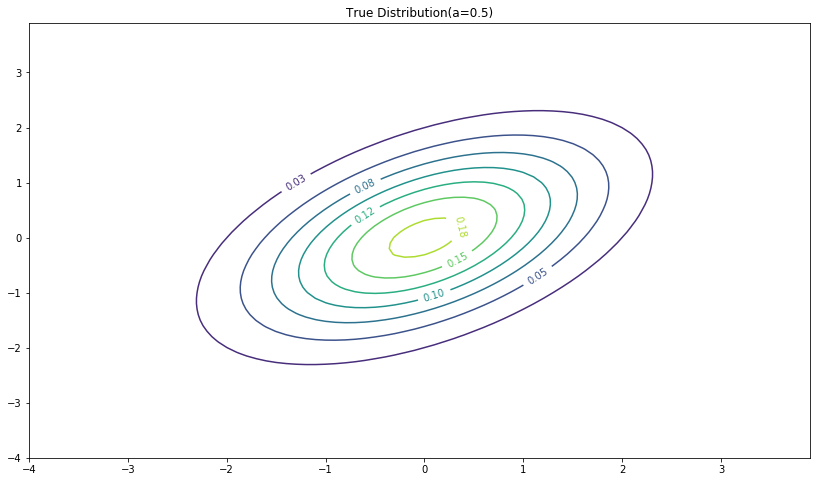

In [ ]:
def gaussian(x, y, mean, co_var):
    output = np.array([])
    x = x - mean[0]
    y = y - mean[1]
    for i in range(x.shape[0]):
        z = 1/(2*math.pi)*math.sqrt(np.linalg.det(co_var))*np.exp(-0.5 * np.dot(np.dot(np.array([x[i, :],y[i, :]]).T, np.linalg.inv(co_var)), np.array([x[i, :],y[i, :]])))
        z = np.diag(z)
        output = np.append(output, z)
    output = output.reshape(x.shape[0], x.shape[0])
    return output

# a : -1<a<1
a = 0.5

Mean = np.array([0, 0])
Cov = 1/(1-a**2) * np.array([[1, a],[a, 1]])

t = np.arange(-4, 4, 0.1)
X, Y = np.meshgrid(t, t)
Z = gaussian(X, Y, Mean, Cov)
plt.title('True Distribution(a={})'.format(a))
c = plt.contour(X, Y, Z)
c.clabel(fmt='%1.2f', fontsize=10)

Text(0.5, 0.92, 'Surface Plot')

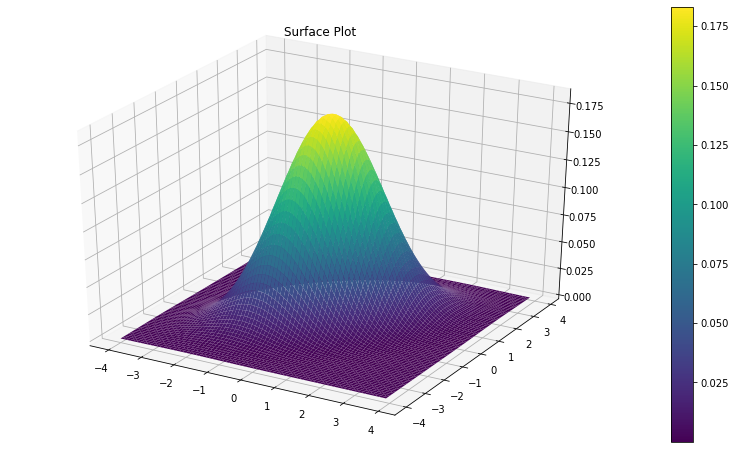

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap='viridis', edgecolor='none')
fig.colorbar(surf)
ax.set_title("Surface Plot")

In [ ]:
def gibbs_sampling(a, step):
    x = 3.5*np.ones(2) # initialize
    samples = x
    for i in range(step):
        x[0] = np.random.normal(a*x[1], 1) # mu=ax[1], sigma=1
        samples = np.append(samples, (x))
        x[1] = np.random.normal(a*x[0], 1)
        samples = np.append(samples, (x))

    samples = samples.reshape((2*step+1, x.shape[0])) # +1 means initial x
    return samples

In [ ]:
step = 3000
samples = gibbs_sampling(a, step)

print(samples[:5])

[[1.47027824 3.5       ]
 [1.47027824 3.5       ]
 [1.47027824 0.42449408]
 [1.11697009 0.42449408]
 [1.11697009 1.26239076]]


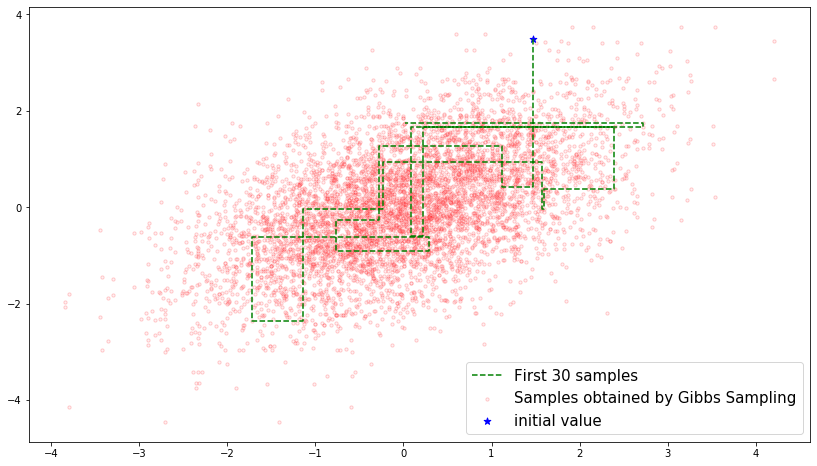

In [ ]:
plt.scatter(samples[:, 0], samples[:, 1], s=10, c='pink', alpha=0.2, edgecolor='red', label='Samples obtained by Gibbs Sampling')
# Tracking Gibbs Sampling
plt.plot(samples[0:30, 0], samples[0:30, 1], color='green', linestyle='dashed', label='First 30 samples')
plt.scatter(samples[0, 0], samples[0, 1], s=50, c='b', marker='*', label='initial value')
plt.legend(loc=4, prop={'size': 15})

In [ ]:
from matplotlib.animation import FuncAnimation

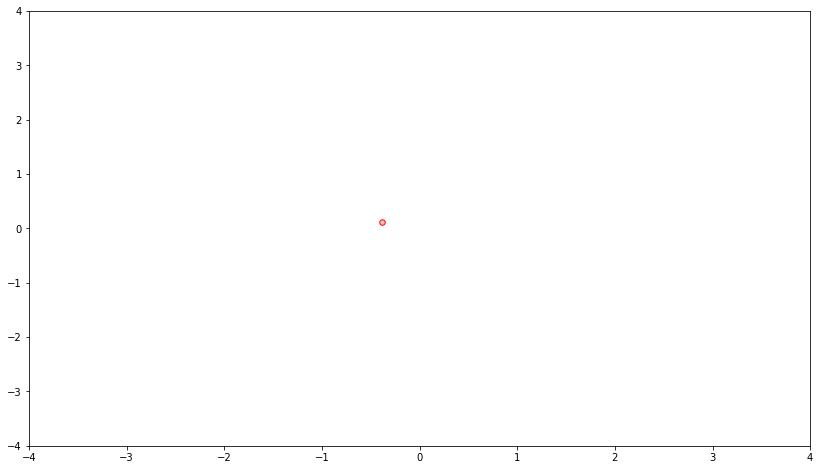

In [ ]:
fig, ax = plt.subplots()
ims = []

x = 3.5*np.ones(2)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)
samples = x

def update_anim(i):
    x[0] = np.random.normal(a*x[1], 1) # mu=ax[1], sigma=1
    x[1] = np.random.normal(a*x[0], 1)

    if len(ims) > 0:
        im = ims.pop()
        im.remove()

    im = ax.scatter(x[0], x[1], s=30, c='pink', edgecolor='red')
    ims.append(im)

anim = FuncAnimation(fig, update_anim, interval=150)
# fig.show()
anim.save('anim.gif', writer='pillow', fps=4)

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

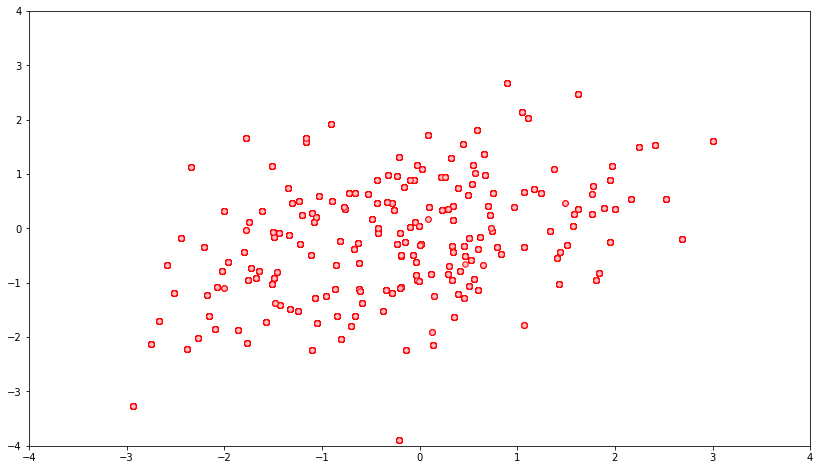

In [ ]:
fig, ax = plt.subplots()
ims = []
xdata, ydata = [], []
ln = plt.scatter([], [], c='r')

x = 3.5*np.ones(2)
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

def update_anim(frame):
    x[0] = np.random.normal(a*x[1], 1) # mu=ax[1], sigma=1
    x[1] = np.random.normal(a*x[0], 1)

    xdata.append(x[0])
    ydata.append(x[1])

    im = ax.scatter(xdata, ydata, s=30, c='pink', edgecolor='red')
    ims.append(im)

# anim = FuncAnimation(fig, update_anim, interval=150, blit=True)
# blit=Trueがあるとエラーが出た
anim = FuncAnimation(fig, update_anim, frames=200, interval=250)
# fig.show()
anim.save('anim.gif', writer='pillow', fps=4)

In [ ]:
from IPython.display import HTML
HTML(anim.to_html5_video())

In [ ]:
from google.colab import files
files.download('anim.gif')

### Error

- [TypeError: 'PathCollection' object is not iterable when adding second legend to plot](https://stackoverflow.com/questions/39984509/typeerror-pathcollection-object-is-not-iterable-when-adding-second-legend-to)
- [matplotlibでimagemagickを使わずにアニメGIFを保存する](https://qiita.com/skotaro/items/430e03b61cc6f069d263)

## Reference

- https://github.com/jojonki/gibbs-sampling/blob/master/gibbs_sampling.pdf
- http://kazufusa1484.hatenablog.com/entry/2017/06/21/133348